In [205]:
from pprint import pprint
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
import edward as ed
from edward.models import Bernoulli, Categorical, Normal, Empirical, Multinomial, Dirichlet, Mixture

from utils.utils import load_dataframe, preprocess, transition_matrix

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)
sns.set_style('whitegrid')

## Data

In [3]:
df = load_dataframe()

Loading raw data from hdf5 cache...
Fetching raw data took 3.71 seconds
id             int64   
loan_status    category
age_of_loan    int64   
term           category
dtype: object
Retrieved 40,263,987 rows, 4 columns


In [4]:
# note I made this filter on term == 36 and age_of_loan <= 36 
df = preprocess(df)

Mapping transformations...
Loading preprocessed data from hdf5 cache...
Fetching preprocessed data took 5.06 seconds
id             int64
loan_status    int64
age_of_loan    int64
term           int64
dtype: object
Preprocessed 27,636,875 rows, 4 columns


In [5]:
realized_transitions = transition_matrix(df)

Loading transition matrix from hdf5 cache...
Fetching transition matrix took 0.11 seconds


In [6]:
realized_transitions

loan_status_y,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
loan_status_x,,,,,,,,
Charged Off,0,0,0,0,0,0,0,0
Current,774,24450170,3,707161,5831,0,160357,62006
Default,28843,147,2206,71,0,0,4,506
Fully Paid,0,0,0,8063,12,0,101,72
In Grace Period,0,276,0,11,22,0,59,41
Issued,0,17206,0,670,1,0,38,1
Late (16-30 days),4548,32374,0,2066,257,0,13413,119613
Late (31-120 days),105932,25398,29748,2138,56,0,3292,332463


## Sampling and visualizing some trajectories:

In [7]:
unique_id = df.id.unique()

In [8]:
unique_id.shape

(1520925,)

In [17]:
statuses = list(realized_transitions.index)

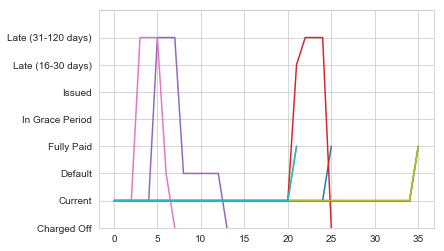

In [27]:
fig, ax = plt.subplots()

ax.set_ylim(0, len(statuses))
ax.set_yticklabels(statuses)

for loan_id in unique_id[:10]:
    ax.plot(df[df.id == loan_id].loan_status.values)

plt.show()

We need to make sure that all trajectories are exactly of length 36, so when they terminate early we should carry on their state until the end (there might be another strategy for that):

First, pivot, to have all trajectories in a matrix:

In [85]:
pivoted = df.pivot(index='id', columns='age_of_loan', values='loan_status')

In [86]:
pivoted.head()

age_of_loan,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54734,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55716,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55742,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
56121,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,7.0,7.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56413,NaN,1.0,1.0,1.0,1.0,1.0,7.0,7.0,7.0,2.0,2.0,2.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
pivoted[0].isnull().mean()

0.9771172148528033

Some loans have a value for month 0?

In [89]:
pivoted[~pivoted[0].isnull()].head()

age_of_loan,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
377140,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN
384586,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582543,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699575,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
767952,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For now let's just drop them:

In [90]:
pivoted = pivoted[pivoted[0].isnull()]

In [91]:
pivoted.shape

(1486122, 37)

In [94]:
pivoted.drop(0, axis=1, inplace=True)

**TODO** count value per column

We can fill the NaNs with an unused category for a state "done":

In [99]:
df.loan_status.unique()

array([1, 3, 6, 7, 0, 2, 4, 5])

In [100]:
new_status = 8

In [102]:
pivoted.fillna(new_status, inplace=True)

In [103]:
pivoted.head()

age_of_loan,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54734,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
55716,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
55742,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
56121,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,7.0,7.0,7.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
56413,1.0,1.0,1.0,1.0,1.0,7.0,7.0,7.0,2.0,2.0,2.0,2.0,2.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0


## Modeling without priors, as a HMM (original github issue model):

**MODEL**

In [110]:
N = pivoted.shape[0]

**TODO figure out how to make sample shape work in this case...**

In [ ]:
# from issue 
chain_len = 36
n_hidden = 10 # set this arbitrarily
n_obs = len(statuses)

x_0 = Categorical(probs=tf.fill([n_hidden], 1.0 / n_hidden), sample_shape=N)

# transition matrix
T = tf.nn.softmax(tf.Variable(tf.random_uniform([n_hidden, n_hidden])), dim=0)

# emission matrix
E = tf.nn.softmax(tf.Variable(tf.random_uniform([n_hidden, n_obs])), dim=0)

# MODEL
x = []
y = []
for _ in range(chain_len):
    x_tm1 = x[-1] if x else x_0
    x_t = Categorical(probs=T[x_tm1, :], sample_shape=N)
    y_t = Categorical(probs=E[x_t, :], sample_shape=N)
    x.append(x_t)
    y.append(y_t)

**INFERENCE**

In [109]:
# INFERENCE
qx = [Categorical(probs=tf.nn.softmax(tf.Variable(tf.ones(n_hidden))))
      for _ in range(chain_len)]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(T))

    inference = ed.KLqp(dict(zip(x, qx)), {y[i]: pivoted[i+1].values for i in range(36)})
    inference.run(n_iter=5000)

    inferred_T, inferred_E = sess.run([T, E])
    inferred_qx = sess.run([foo.probs for foo in qx])
    inferred_y_probs = sess.run([foo.probs for foo in y])
    print(inferred_T)
    print(inferred_E)

[[0.07206143 0.12621807 0.07430386 0.11580846 0.10561596 0.11710213
  0.10177287 0.15219013 0.0746849  0.07667297]
 [0.07417307 0.12157483 0.14305042 0.07597164 0.04938179 0.09361589
  0.09935647 0.06896559 0.08839097 0.11041027]
 [0.10551019 0.05773136 0.11119609 0.12431424 0.10773064 0.08708536
  0.12719439 0.10971747 0.06603501 0.10360218]
 [0.08340812 0.09245151 0.06698961 0.06164568 0.09094778 0.08827589
  0.11453547 0.09928253 0.07408199 0.14156681]
 [0.16348484 0.1168147  0.14356631 0.1160583  0.12170757 0.10884484
  0.14178085 0.06634106 0.1257334  0.14454736]
 [0.11198653 0.08035402 0.06470726 0.13834995 0.12605292 0.13403639
  0.07330478 0.14098755 0.11148169 0.07560604]
 [0.09072173 0.12771279 0.08710171 0.08346995 0.11746054 0.09642113
  0.08160175 0.06222953 0.13799557 0.08404624]
 [0.07568236 0.0634633  0.12212493 0.1391165  0.09919841 0.12725583
  0.1351074  0.06942367 0.09561607 0.09785486]
 [0.14321809 0.1332826  0.07351752 0.0827241  0.10455215 0.08303951
  0.06816918

TypeError: Key-value pair in data does not have same shape: (), (1486122,)

## Modeling with priors:

### Test 1: works, converges to NaN

**MODEL**

Debug: train on subset of data

In [160]:
N = 100

In [161]:
subset_pivoted = pivoted.sample(N)

Need to reshape the pi passed to categorical with .reshape(1,-1) but they are RV (or Tensors)...

In [232]:
tf.reset_default_graph()
chain_len = 36
n_hidden = 9

x_0 = Categorical(Dirichlet(tf.ones(n_hidden), sample_shape=N))

# transition matrix
pi_T = [Dirichlet(tf.ones(n_hidden), sample_shape=N) for i in range(n_hidden)]
T = [Categorical(probs=pi) for pi in pi_T]

# MODEL
x = []
for _ in range(chain_len):
    x_tm1 = x[-1] if x else x_0
    x_t = ed.models.Mixture(cat=Categorical(probs=tf.one_hot(x_tm1, n_hidden, axis=1)),
                            components=T)
    x.append(x_t)

In [239]:
x[1].shape

TensorShape([Dimension(100)])

**INFERENCE (VI)**:

**TODO** train by batch

Even with 100 data points, reaches NaN loss after around 200 iter...
=> some rows become full of NaN. There is no rule on which rows become NaN

In [167]:
# INFERENCE
# qpi_T = [Dirichlet(tf.nn.softmax(tf.Variable(tf.ones(n_hidden)))) for i in range(n_hidden)]
qpi_T = [Dirichlet(tf.nn.softplus(tf.Variable(tf.ones(n_hidden))), sample_shape=N) for i in range(n_hidden)]

latent_vars_map = dict(zip(pi_T, qpi_T))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    inference = ed.KLqp(latent_vars_map, {x[i]: subset_pivoted[i+1].values for i in range(36)})
    inference.run(n_iter=500)
    inferred_qpi_T = sess.run([qpi.mean() for qpi in qpi_T])

500/500 [100%] ██████████████████████████████ Elapsed: 30s | Loss: nan


In [168]:
inferred_qpi_T

[array([nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32),
 array([0.07384682, 0.17054522, 0.06831836, 0.15588123, 0.14173023,
        0.03249849, 0.1121012 , 0.22538446, 0.01969401], dtype=float32),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32),
 array([0.06336016, 0.02734108, 0.32009676, 0.08596516, 0.19903316,
        0.06545154, 0.0270051 , 0.18944427, 0.02230282], dtype=float32),
 array([0.08770145, 0.18512449, 0.07122654, 0.14352211, 0.08422772,
        0.16036335, 0.15330315, 0.04561149, 0.06891966], dtype=float32),
 array([0.23260267, 0.16315797, 0.05219817, 0.0238652 , 0.20017566,
        0.06893615, 0.03613373, 0.19205803, 0.03087245], dtype=float32),
 array([0.03702281, 0.05152034, 0.13557236, 0.21328911, 0.08953208,
        0.22512904, 0.05562092, 0.09028555, 0.1020278 ], dtype=float32),
 array([0.03403175, 0.2103253 , 0.13745536, 0.11820544, 0.11507049,
        0.1277651 , 0.12529531, 0.11969975, 0.01215148], dtype=float32),
 array([nan, n

This error might be related to this: https://github.com/blei-lab/edward/issues/724. (bad implementation of log prob in TF; yet our version of TF is more recent than the issue)

**Note:** It seems like we should only specify sample_shape=N for outputs of the model. But Mixtures also need cat and components to have the right sample_shape.